# 💓 Heart Disease Prediction Project

## 📌 Goal

Build a machine learning pipeline that can predict whether a person is likely to have heart disease based on clinical features. This tool aims to assist in early detection and encourage timely medical follow-up.

# 🧠 Problem Motivation

Heart disease is one of the leading causes of death worldwide. Early detection is critical for treatment and prevention. By leveraging clinical data and machine learning, we aim to build a predictive model that can:

- Provide a second opinion to healthcare providers.

- Raise awareness for patients at risk.

- Be deployed as a simple, interactive web app.

# 📁 Dataset and Features

We use a structured dataset where each row represents a patient, and columns represent clinical measurements.

## Selected Features:

- oldpeak

- sex

- exercise angina

- fasting blood sugar

- chest pain type

- cholesterol

- max heart rate

- resting bp s

- age

- resting ecg

- ST slope

## Target:

target: 1 = Heart Disease, 0 = No Disease

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
import joblib
import json
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the dataset
df = pd.read_csv('dataset.csv')

In [3]:
# Display the first few rows
df.head()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [4]:
# Basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1190 non-null   int64  
 1   sex                  1190 non-null   int64  
 2   chest pain type      1190 non-null   int64  
 3   resting bp s         1190 non-null   int64  
 4   cholesterol          1190 non-null   int64  
 5   fasting blood sugar  1190 non-null   int64  
 6   resting ecg          1190 non-null   int64  
 7   max heart rate       1190 non-null   int64  
 8   exercise angina      1190 non-null   int64  
 9   oldpeak              1190 non-null   float64
 10  ST slope             1190 non-null   int64  
 11  target               1190 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 111.7 KB


In [5]:
# Check for missing values
df.isnull().sum()


age                    0
sex                    0
chest pain type        0
resting bp s           0
cholesterol            0
fasting blood sugar    0
resting ecg            0
max heart rate         0
exercise angina        0
oldpeak                0
ST slope               0
target                 0
dtype: int64

In [6]:
features = ['oldpeak', 'sex', 'exercise angina', 'fasting blood sugar',
            'chest pain type', 'cholesterol', 'max heart rate',
            'resting bp s', 'age', 'resting ecg', 'ST slope']
X = df[features]
y = df['target']

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(probability=True),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

# Evaluate each model
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else np.zeros_like(y_pred)
    
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba)
    })

# Display results
results_df = pd.DataFrame(results).sort_values(by='F1 Score', ascending=False)
results_df.reset_index(drop=True, inplace=True)
results_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Random Forest,0.909396,0.933775,0.892405,0.912621,0.970434
1,Gradient Boosting,0.895973,0.909677,0.892405,0.900958,0.951808
2,Decision Tree,0.869128,0.904762,0.841772,0.872131,0.870886
3,AdaBoost,0.845638,0.845679,0.867089,0.856250,0.922672
4,Logistic Regression,0.838926,0.852564,0.841772,0.847134,0.909629
5,K-Nearest Neighbors,0.711409,0.722222,0.740506,0.731250,0.784697
6,Support Vector Machine,0.718121,0.753425,0.696203,0.723684,0.791998


# Hyperparameter Tuning the top three models

In [ ]:
def run_grid_search(model, param_grid, model_name):
    print(f"Tuning {model_name}...")
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='f1',
        cv=5,
        n_jobs=-1,
        verbose=2
    )
    grid.fit(X_train_scaled, y_train)
    print(f"Best F1 score for {model_name}: {grid.best_score_:.4f}")
    print(f"Best Parameters for {model_name}: {grid.best_params_}")
    return grid.best_estimator_

# Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
best_rf = run_grid_search(RandomForestClassifier(random_state=42), param_grid_rf, "Random Forest")

# Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 150],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7]
}
best_gb = run_grid_search(GradientBoostingClassifier(random_state=42), param_grid_gb, "Gradient Boosting")

# Decision Tree
param_grid_dt = {
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
best_dt = run_grid_search(DecisionTreeClassifier(random_state=42), param_grid_dt, "Decision Tree")


Random Forest - Accuracy: 0.9128, F1: 0.9128
Gradient Boosting - Accuracy: 0.8993, F1: 0.8994
Decision Tree - Accuracy: 0.8557, F1: 0.8558


# Various ensemble methods

In [12]:
bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=100,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    random_state=42
)

bagging_model.fit(X_train, y_train)
y_pred_bag = bagging_model.predict(X_test)
y_proba_bag = bagging_model.predict_proba(X_test)[:, 1]

print("Bagging Classifier Report:\n", classification_report(y_test, y_pred_bag))
print("Bagging Classifier Accuracy:", accuracy_score(y_test, y_pred_bag))
print("Bagging Classifier F1 Score:", f1_score(y_test, y_pred_bag))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_bag))
print("ROC AUC:", roc_auc_score(y_test, y_proba_bag))


Bagging Classifier Report:
               precision    recall  f1-score   support

           0       0.88      0.91      0.90       140
           1       0.92      0.89      0.91       158

    accuracy                           0.90       298
   macro avg       0.90      0.90      0.90       298
weighted avg       0.90      0.90      0.90       298

Bagging Classifier Accuracy: 0.9026845637583892
Bagging Classifier F1 Score: 0.9067524115755627
Confusion Matrix:
 [[128  12]
 [ 17 141]]
ROC AUC: 0.9572106690777578


In [13]:
voting = VotingClassifier(
    estimators=[
        ('rf', best_rf),
        ('gb', best_gb),  
        ('svc', best_dt)     
    ],
    voting='soft'
)

voting.fit(X_train, y_train)

y_pred_vote = voting.predict(X_test)
y_proba_vote = voting.predict_proba(X_test)[:, 1]

print("Voting Classifier Report:\n", classification_report(y_test, y_pred_vote))
print("Voting Classifier Accuracy:", accuracy_score(y_test, y_pred_vote))
print("Voting Classifier F1 Score:", f1_score(y_test, y_pred_vote))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_vote))
print("ROC AUC:", roc_auc_score(y_test, y_proba_vote))

Voting Classifier Report:
               precision    recall  f1-score   support

           0       0.87      0.91      0.89       140
           1       0.92      0.88      0.90       158

    accuracy                           0.90       298
   macro avg       0.90      0.90      0.90       298
weighted avg       0.90      0.90      0.90       298

Voting Classifier Accuracy: 0.8959731543624161
Voting Classifier F1 Score: 0.8996763754045307
Confusion Matrix:
 [[128  12]
 [ 19 139]]
ROC AUC: 0.9646021699819167


In [14]:
estimators = [
    ('rf', best_rf),
    ('gb', best_gb),
    ('svc', best_dt)
]

# Meta-model: Logistic Regression
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=10000),
    cv=5,
    passthrough=True,  # Optional: allows meta-model to access original features too
    n_jobs=-1
)

# Train
stacking_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_stack = stacking_model.predict(X_test)
y_proba_stack = stacking_model.predict_proba(X_test)[:, 1]

print("Stacking Classifier Report:\n", classification_report(y_test, y_pred_stack))
print("Stacking Classifier Accuracy:", accuracy_score(y_test, y_pred_stack))
print("Stacking Classifier F1 Score:", f1_score(y_test, y_pred_stack))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_stack))
print("ROC AUC:", roc_auc_score(y_test, y_proba_stack))

Stacking Classifier Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.91       140
           1       0.93      0.89      0.91       158

    accuracy                           0.91       298
   macro avg       0.91      0.91      0.91       298
weighted avg       0.91      0.91      0.91       298

Stacking Classifier Accuracy: 0.9093959731543624
Stacking Classifier F1 Score: 0.912621359223301
Confusion Matrix:
 [[130  10]
 [ 17 141]]
ROC AUC: 0.9650542495479204


In [15]:
# We'll evaluate models using F1 score on full data
cv_scores = {}

for name, model in models.items():
    try:
        # Create a pipeline with scaling + model (ensures fair comparison)
        pipeline = make_pipeline(StandardScaler(), model)
        scores = cross_val_score(pipeline, X, y, cv=5, scoring="f1")
        cv_scores[name] = np.mean(scores)
        print(f"{name}: Mean F1 = {np.mean(scores):.4f}, Std = {np.std(scores):.4f}")
    except Exception as e:
        print(f"{name} failed: {e}")


Logistic Regression: Mean F1 = 0.8228, Std = 0.0386
K-Nearest Neighbors: Mean F1 = 0.8505, Std = 0.0319
Support Vector Machine: Mean F1 = 0.8622, Std = 0.0308
Decision Tree: Mean F1 = 0.8776, Std = 0.0773
Random Forest: Mean F1 = 0.9391, Std = 0.0330
AdaBoost: Mean F1 = 0.8477, Std = 0.0469
Gradient Boosting: Mean F1 = 0.8870, Std = 0.0253


# Visualizing the best Features

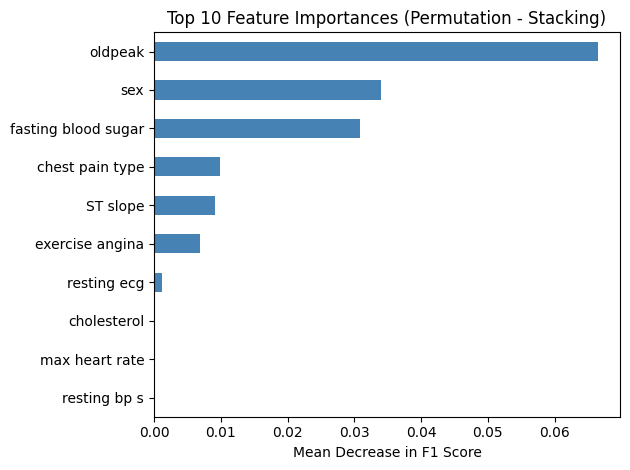

Top 10 Permutation Features:
1. oldpeak
2. sex
3. fasting blood sugar
4. chest pain type
5. ST slope
6. exercise angina
7. resting ecg
8. cholesterol
9. max heart rate
10. resting bp s


In [16]:
# Compute permutation importance
result = permutation_importance(
    stacking_model,
    X_test_scaled,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring='f1_weighted'
)

# Convert to Series with feature names
perm_importances = pd.Series(result.importances_mean, index=X.columns)

# Get top 10 features
top_10_features = perm_importances.sort_values(ascending=False).head(10)

# Plot in descending order (top to bottom)
top_10_features[::-1].plot(kind='barh', color='steelblue')
plt.title("Top 10 Feature Importances (Permutation - Stacking)")
plt.xlabel("Mean Decrease in F1 Score")
plt.tight_layout()
plt.show()

# Print feature names
print("Top 10 Permutation Features:")
for i, feat in enumerate(top_10_features.index, 1):
    print(f"{i}. {feat}")


In [17]:
joblib.dump(stacking_model, 'best_model.pkl')
correct_feature_names = ['oldpeak', 'sex', 'exercise angina', 'fasting blood sugar',
                         'chest pain type', 'cholesterol', 'max heart rate',
                         'resting bp s', 'age', 'resting ecg', 'ST slope']
joblib.dump(correct_feature_names, "feature_names.pkl")
joblib.dump(perm_importances, 'permutation_importance.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [18]:
metrics = {'accuracy': acc, 'f1_score': f1}
with open('metrics.json', 'w') as f:
    json.dump(metrics, f)